In [2]:
from __future__ import print_function

import numpy as np
import pickle
import pandas as pd

from keras.optimizers import SGD
from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import regularizers

Using TensorFlow backend.


In [3]:
#set parameters

batch_size = 50
hidden_units = 10
nb_classes = 16
num_lstm_units = 350 #or 64?
num_epochs = 30

In [4]:
mfcc_filename = "mfccs_dev_22050.csv"
dataset = pd.read_csv(mfcc_filename)
df = pd.DataFrame(dataset)
mfcc_data = df[["mfcc_mean1","mfcc_mean2","mfcc_mean3","mfcc_mean4","mfcc_mean5","mfcc_mean6","mfcc_mean7","mfcc_mean8","mfcc_mean9","mfcc_mean10","mfcc_mean11","mfcc_mean12","mfcc_mean13"]]
test_dim = mfcc_data.shape[0]

#set up targets (labels)
accent_data = pd.read_csv("cv-valid-dev-acc-mp3.csv")
targets_raw = np.array(accent_data['accent'])

label_encoder = LabelEncoder()
mfcc_targets = label_encoder.fit_transform(targets_raw)

X_train,X_test,y_train,y_test = train_test_split(
    mfcc_data,mfcc_targets,test_size=0.20,random_state=42
)

X_train = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.values.reshape(X_test.shape[0], X_test.shape[1],1)

print(len(X_train), 'train sequences')
print(len(X_test), 'test sequences')
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

1080 train sequences
270 test sequences
X_train shape: (1080, 13, 1)
X_test shape: (270, 13, 1)
y_train shape: (1080,)
y_test shape: (270,)


In [19]:
#build model
model = Sequential()

# model.add(LSTM(num_lstm_units, return_sequences=True, stateful=False,
#                batch_input_shape=(batch_size, X_train.shape[1], X_train.shape[2])))
# model.add(LSTM(num_lstm_units, return_sequences=True, stateful=False))
# model.add(LSTM(num_lstm_units, stateful=False))
model.add(LSTM(num_lstm_units,return_sequences=True,input_shape=(X_train.shape[1],X_train.shape[2])))
model.add(LSTM(num_lstm_units, return_sequences=True, stateful=False))
model.add(LSTM(num_lstm_units, stateful=False))

# We flatten the output of the conv layer,
# so that we can add a vanilla dense layer:
# model.add(Flatten())

model.add(Dense(250))

# add dropout to control for overfitting
model.add(Dropout(.25))

# squash output onto number of classes in probability space
model.add(Dense(nb_classes, activation='softmax'
#                 kernel_regularizer=regularizers.l2(1e-5)
#                kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)
               ))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])
model.summary()
history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=num_epochs,
                   validation_data=(X_test, Y_test), verbose = 1)

y_pred = model.predict_classes(X_test, batch_size=batch_size)
print(classification_report(y_test, y_pred))

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 13, 350)           492800    
_________________________________________________________________
lstm_21 (LSTM)               (None, 13, 350)           981400    
_________________________________________________________________
lstm_22 (LSTM)               (None, 350)               981400    
_________________________________________________________________
dense_18 (Dense)             (None, 250)               87750     
_________________________________________________________________
dropout_11 (Dropout)         (None, 250)               0         
_________________________________________________________________
dense_19 (Dense)             (None, 16)                4016      
Total params: 2,547,366
Trainable params: 2,547,366
Non-trainable params: 0
___________________________________________

/Users/yeojin_jung/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/yeojin_jung/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


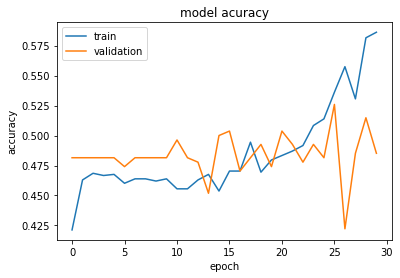

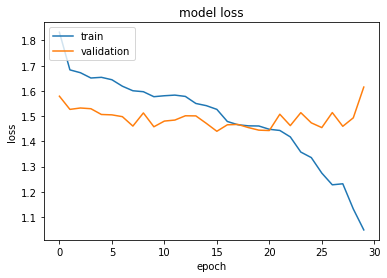

In [20]:
from keras.callbacks import History 
import matplotlib.pyplot as plt

print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model acuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()